# Rice Classification Using Pytorch(Pytorch Demo)

## Importing Libraries, Downloading and Visualizing Data

In [1]:
# Getting the dataset

import opendatasets as od

od.download('https://www.kaggle.com/datasets/mssmartypants/rice-type-classification')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  ankitdey0811


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 888k/888k [00:00<00:00, 209MB/s]

In [2]:
# Importing all libraries

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Check if GPU is recognized or not

print(device)

cuda


In [4]:
# Visualizing the dataset

data_df = pd.read_csv("datasets/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


- The ID column is irrelevant for our purpose.
- Also, for our purpose let us remove all columns with empty values.

In [5]:
# Primitive Data Preprocessing

data_df.dropna(inplace=True)
data_df.drop(["id"], axis = 1, inplace=True)

In [6]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [7]:
print(data_df.shape)

(18185, 11)


## Data Preprocessing

In [8]:
original_df = data_df.copy() # Creating a copy of the original Dataframe to use to normalize inference

for column in data_df.columns:
    data_df[column] = data_df[column]/data_df[column].abs().max()

In [9]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


### Data Splitting

In [10]:
X = np.array(data_df.iloc[:, :-1])
y = np.array(data_df.iloc[:, -1])

# Train = 70%, Test & Val = 15%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

In [11]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)


## Building Model & Training

In [12]:
# Creating a dataset

class dataset(Dataset): # Inherits the Dataset class from torch

    # Constructor
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype = torch.float32).to(device)
        self.Y = torch.tensor(y, dtype = torch.float32).to(device)

    # Custom overriden helper functions
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

# Creating our train, test, val datasets as objects
train_data = dataset(X_train, y_train)
test_data = dataset(X_test, y_test)
val_data = dataset(X_val, y_val)

In [13]:
# Deciding hyperparameters

BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_NEURONS = 10
LEARNING_RATE = 1e-3

In [14]:
# Using dataloaders to actually load data batch wise onto the gpu

train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = True)


In [15]:
# Modeling our Neural Network

class MyModel(nn.Module):

    def __init__(self):

        super(MyModel, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS) # ip neurons, op neurons
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()

    # Forward Prop
    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x


In [16]:
# Getting model summary

model = MyModel().to(device)
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [17]:
# Choosing loss and optimizer

criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = LEARNING_RATE)

In [18]:
# Training Loop

total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(EPOCHS):
    total_acc_train_epoch = 0
    total_loss_train_epoch = 0
    total_acc_val_epoch = 0
    total_loss_val_epoch = 0

    # Training Loop
    for data in train_dataloader:
        inputs, labels = data
        pred = model(inputs).squeeze(1)
        batch_loss = criterion(pred, labels)
        total_loss_train_epoch += batch_loss.item()
        acc = ((pred).round() == labels).sum().item()
        total_acc_train_epoch += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # For validation claculation
    with torch.no_grad(): # Disable gradient computation
        for data in val_dataloader:
            inputs, labels = data
            pred = model(inputs).squeeze(1)
            batch_loss = criterion(pred, labels)
            total_loss_val_epoch += batch_loss.item()
            acc = ((pred).round() == labels).sum().item()
            total_acc_val_epoch += acc

    total_loss_train_plot.append(round(total_loss_train_epoch / 1000, 4))
    total_loss_val_plot.append(round(total_loss_val_epoch / 1000, 4))
    total_acc_train_plot.append(round(total_acc_train_epoch / (train_data.__len__()) * 100, 4))
    total_acc_val_plot.append(round(total_acc_val_epoch / val_data.__len__() * 100, 4))

    print(f'''Epoch {epoch + 1}:
    Train Loss: {total_loss_train_epoch / 1000:.4f} Train Accuracy: {total_acc_train_epoch / (train_data.__len__()) * 100:.4f}
    Val Loss: {total_loss_val_epoch / 1000:.4f} Val Accuracy: {total_acc_val_epoch / (val_data.__len__()) * 100:.4f}''')
    print("="*60)



Epoch 1:
    Train Loss: 0.2540 Train Accuracy: 78.4665
    Val Loss: 0.0459 Val Accuracy: 95.3446
Epoch 2:
    Train Loss: 0.1535 Train Accuracy: 97.3918
    Val Loss: 0.0216 Val Accuracy: 97.8006
Epoch 3:
    Train Loss: 0.0710 Train Accuracy: 98.1145
    Val Loss: 0.0113 Val Accuracy: 98.2038
Epoch 4:
    Train Loss: 0.0416 Train Accuracy: 98.3974
    Val Loss: 0.0076 Val Accuracy: 98.4971
Epoch 5:
    Train Loss: 0.0303 Train Accuracy: 98.5859
    Val Loss: 0.0061 Val Accuracy: 98.6437
Epoch 6:
    Train Loss: 0.0248 Train Accuracy: 98.5938
    Val Loss: 0.0053 Val Accuracy: 98.4604
Epoch 7:
    Train Loss: 0.0218 Train Accuracy: 98.6330
    Val Loss: 0.0047 Val Accuracy: 98.6804
Epoch 8:
    Train Loss: 0.0200 Train Accuracy: 98.5781
    Val Loss: 0.0046 Val Accuracy: 98.6804
Epoch 9:
    Train Loss: 0.0187 Train Accuracy: 98.6330
    Val Loss: 0.0043 Val Accuracy: 98.6437
Epoch 10:
    Train Loss: 0.0180 Train Accuracy: 98.6802
    Val Loss: 0.0043 Val Accuracy: 98.6804


## Testing & Plotting

In [19]:

with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for data in test_dataloader:
        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss_test = criterion((prediction), labels)
        total_loss_test += batch_loss_test.item()
        acc = ((prediction).round() == labels).sum().item()
        total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 98.5%


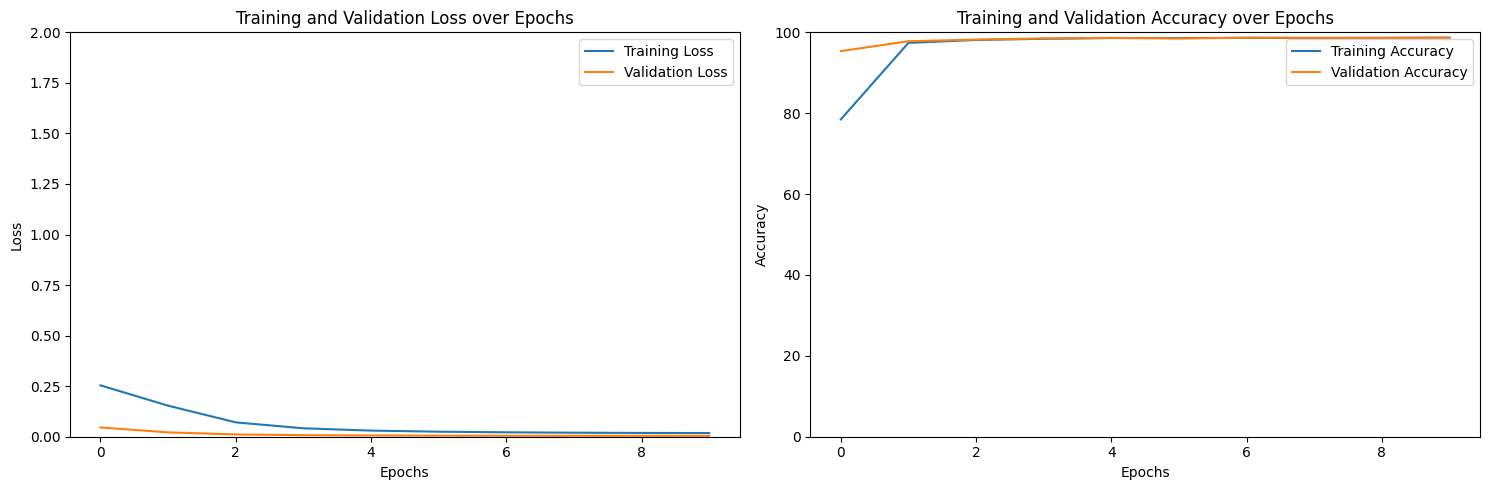

In [20]:


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()
